In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

In [2]:
def gaussian(x, x0=0, A=1, sigma=.5):
    return A*np.exp(-(x-x0)**2/sigma)

# Create a set of test data

Generate three gaussian peaks with a small background

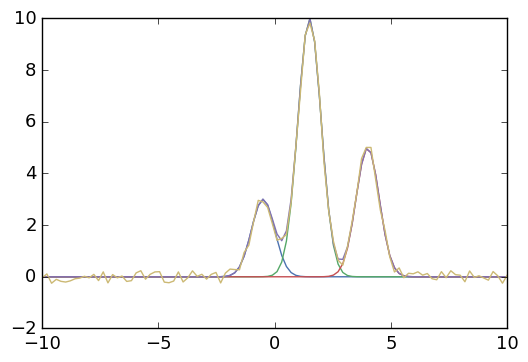

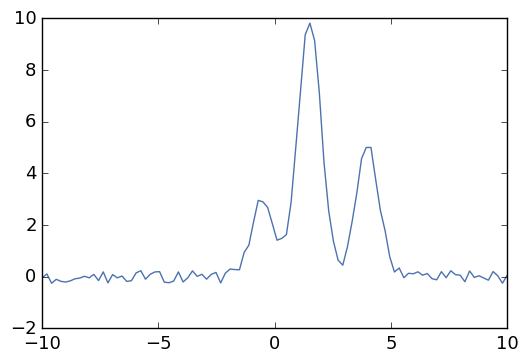

In [3]:
np.random.seed(1)
sources = [(-.5, 3, .5), (1.5, 10, .5), (4, 5, .5)]

x = np.linspace(-10,10,100)
y = np.zeros(x.shape)
for src in sources:
    src_y = gaussian(x, src[0], src[1], src[2])
    y += src_y
    plt.plot(x, src_y)
noise = np.random.rand(len(x))/2-.25
data = y + noise
plt.plot(x,y)
plt.plot(x, data)
plt.show()

plt.plot(x, data)
plt.show()

# Create peak templates

For each peak create a symmetric template

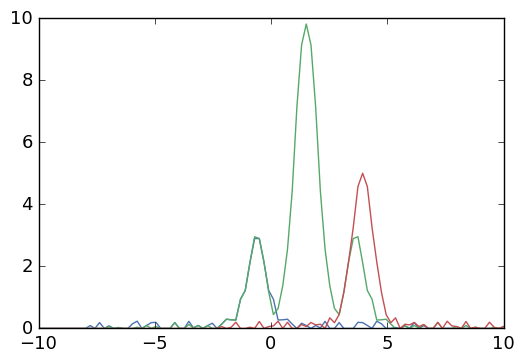

In [4]:
def initTemplate1D(x0, x, data):
    template = np.zeros(x.shape)
    pIdx = np.argmin(np.abs(x-x0))
    if pIdx<x.shape[0]/2:
        xmin = 0
        xmax = 2*pIdx
    elif pIdx>x.shape[0]/2:
        xmin = x.shape[0]-1-(x.shape[0]-1-pIdx)*2
        xmax = x.shape[0]
    #print(x0, x[pIdx], x[xmin], x[xmax], pIdx, xmin, xmax)
    
    # Get the minimum pixels symmetric around the peak
    subData = data[xmin:xmax]
    invData = subData[::-1]
    subTemp = np.minimum(subData, invData)
    template[xmin:xmax] = subTemp
    return template

def initWH1D(sources, x, data):
    W = np.ones(len(sources))
    H = np.zeros((W.shape[0], data.shape[0]))
    for k, src in enumerate(sources):
        template = initTemplate1D(src[0], x, data)
        H[k] = template
    return W, H

# For simplicity, make data positive
data[data<0] = 0
initW, initH = initWH1D(sources, x, data)
for template in initH:
    plt.plot(x,template)

# Create and test the monotonic operator

100


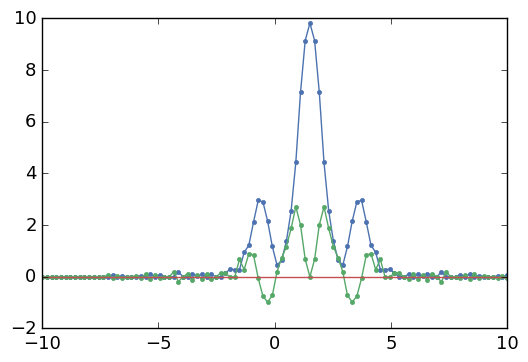

In [11]:
import scipy.sparse
plt.plot(x,initH[1], '.-')
width =len(initH[1])
print(width)
px = np.argmin((x-1.5)**2)

x1 = scipy.sparse.diags([-1,1], [0,1], shape=(px, px))
x2 = scipy.sparse.coo_matrix([[0]])
x3 = scipy.sparse.diags([1,-1], [-1,0], shape=(width-px-1, width-px-1))
monoX = scipy.sparse.block_diag((x1, x2, x3))
monoX += scipy.sparse.coo_matrix(([1],([px-1],[px])), shape=(monoX.shape))
monoX += scipy.sparse.coo_matrix(([1],([px+1],[px])), shape=(monoX.shape))

plt.plot(x,monoX.dot(initH[1]), '.-')
plt.plot(x, np.zeros_like(x))

In [8]:
monoX.toarray()[px-3:px+4, px-3:px+4]

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1.]])

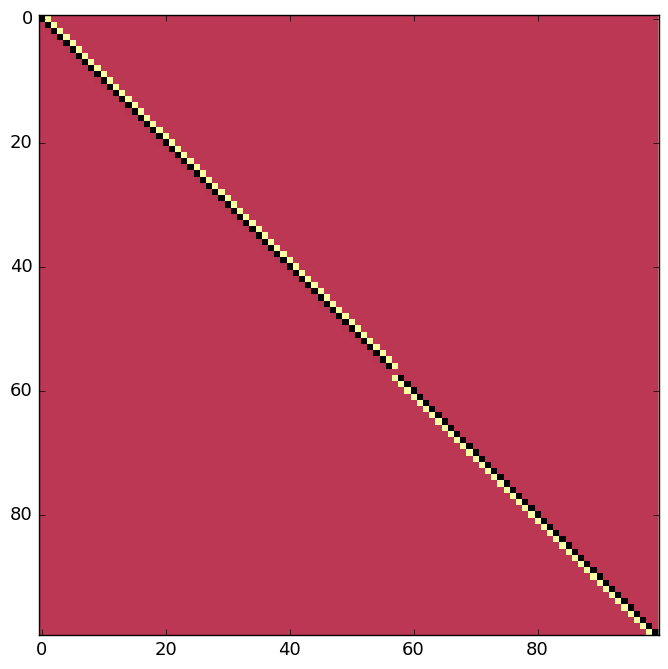

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(monoX.toarray(), interpolation='none', cmap='inferno')